In [ ]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7MB 57kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.metrics import confusion_matrix

In [ ]:
### defining some parameters.

class config:
    CDNN_SHAPE = (400, 400) ### the shape of input images for DCNN 
    TRAINING_SET_SIZE = 400 ### number of training samples
    TESTING_SET_SIZE = 400 ### number of testing samples
    VALIDATION_SET_SIZE = 100 ### number of validation samples 
    N_CLUSTER = 50 ### NUMBER OF VISUAL WORDS  *OR*  NUMBER OF FEATURES  *OR*  number of clusters

In [ ]:
path_dataset = '/content/drive/MyDrive/NEW_DATASET'
#path_dataset = '/content/drive/MyDrive/projects/estee/NEW_DATASET' ### soheil

b_images = os.listdir(path_dataset+'/BONAFIDEA') ### get all of `bonafide` files name
m_images = os.listdir(path_dataset+'/morphed') ### get all of `morphed` files name

print(f'number of Bonafide images: {len(b_images)}\nnumber of Morphed images: {len(m_images)}')

number of Bonafide images: 920
number of Morphed images: 1066


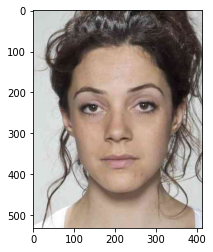

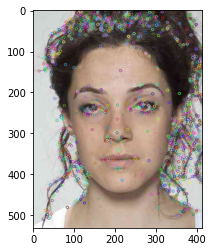

In [ ]:
### showing one Bonafide image with and without keypoints
sift = cv2.SIFT_create()
img = cv2.imread(path_dataset+"/BONAFIDEA/"+b_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
k, des = sift.detectAndCompute(img,None)
plt.figure()
plt.imshow(img)
plt.show()
img = cv2.drawKeypoints(img, k, img)
plt.imshow(img)
plt.show()

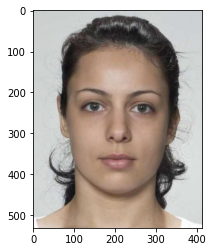

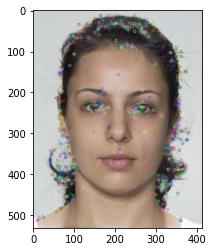

In [ ]:
### showing one Morphed image with and without keypoints

sift = cv2.SIFT_create()
img = cv2.imread(path_dataset+"/morphed/"+m_images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
k, des = sift.detectAndCompute(img,None)
plt.figure()
plt.imshow(img)
plt.show()
img = cv2.drawKeypoints(img, k, img)
plt.imshow(img)
plt.show()

In [ ]:
### creating a Pandas Dataframe with file name and class type (morphe/bonafide)

df_all = pd.DataFrame(b_images,columns=['file'])
df_all['class'] = 0
df_all_ = pd.DataFrame(m_images,columns=['file'])
df_all_['class'] = 1
df_all = pd.concat((df_all, df_all_),axis=0)

In [ ]:
### train test split. I used stratify to keep distribution of the whole dataset

X_train, X_test, y_train, y_test = train_test_split(df_all['file'].to_numpy(), 
                                                    df_all['class'].to_numpy(), 
                                                    test_size=0.33, 
                                                    random_state=1370,
                                                    stratify=df_all['class'])

## Creating BoVW for train-set and test-set

In [ ]:
### a function to load and find keypoints using SIFT function and returning only the descriptor (128 element vector)

def cal_sift(X, y):

    descriptor = []
    sift = cv2.SIFT_create()

    for x_, y_ in zip(X, y):

        type_f = '/BONAFIDEA/' if y_==0 else '/morphed/'
        img = cv2.imread(path_dataset+type_f+x_)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        _, des = sift.detectAndCompute(img,None)  ### position of key points
        descriptor.append(des)
        
    return descriptor

### applying the above function on part of train set (all of train-set would take time)
descriptor_res = cal_sift(X_train[:config.TRAINING_SET_SIZE], 
                          y_train[:config.TRAINING_SET_SIZE])

### vertical stacking to train a clustering model 
descriptor_res_ = descriptor_res[0]

for ii_ in range(1,len(descriptor_res)):
    descriptor_res_ = np.vstack((descriptor_res_, 
                                 descriptor_res[ii_]))
    
### training the clustering model (Kmeans)
kmeans = KMeans(n_clusters=config.N_CLUSTER)
kmeans.fit(descriptor_res_)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
### using the trained clustering model to find the number of visual word in each image of training set

im_features_train = np.zeros((len(descriptor_res), config.N_CLUSTER))

for i_ in range(len(descriptor_res)):
    for j_ in range(descriptor_res[i_].shape[0]):
        pred = kmeans.predict(descriptor_res[i_][j_,:].reshape(1, 128))[0]
        im_features_train[i_,pred] +=1

im_features_train = im_features_train.astype(int)

In [ ]:
### calculating SIFT for validation set 
descriptor_res_val = cal_sift(X_train[config.TRAINING_SET_SIZE:config.VALIDATION_SET_SIZE+config.TRAINING_SET_SIZE], 
                              y_train[config.TRAINING_SET_SIZE:config.VALIDATION_SET_SIZE+config.TRAINING_SET_SIZE])

### using the trained clustering model to find the number of visual word in each image of validation set 
im_features_val = np.zeros((len(descriptor_res_val), config.N_CLUSTER))

for i_ in range(len(descriptor_res_val)):
    for j_ in range(descriptor_res_val[i_].shape[0]):
        pred = kmeans.predict(descriptor_res_val[i_][j_, :].reshape(1, 128))[0]
        im_features_val[i_,pred] += 1

im_features_val = im_features_val.astype(int)

In [ ]:
### calculating SIFT for testing set 
descriptor_res_test = cal_sift(X_test[:config.TESTING_SET_SIZE], 
                               y_test[:config.TESTING_SET_SIZE])

### using the trained clustering model to find the number of visual word in each image of testing set 
im_features_test = np.zeros((len(descriptor_res_test), config.N_CLUSTER))

for i_ in range(len(descriptor_res_test)):
    for j_ in range(descriptor_res_test[i_].shape[0]):
        pred = kmeans.predict(descriptor_res_test[i_][j_, :].reshape(1, 128))[0]
        im_features_test[i_,pred] += 1

im_features_test = im_features_test.astype(int)

## Training XGBoost classifier

In [ ]:
### having the number of visual words in each image, we can train a classifier

import xgboost

model_xgb = xgboost.XGBClassifier()

val_set = [(im_features_val, 
            y_train[config.TRAINING_SET_SIZE:config.VALIDATION_SET_SIZE+config.TRAINING_SET_SIZE])]

model_xgb.fit(im_features_train, 
              y_train[:config.TRAINING_SET_SIZE], 
              eval_metric='error',
              early_stopping_rounds=10, 
              eval_set=val_set )


[0]	validation_0-error:0.24
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.24
[2]	validation_0-error:0.27
[3]	validation_0-error:0.27
[4]	validation_0-error:0.27
[5]	validation_0-error:0.21
[6]	validation_0-error:0.21
[7]	validation_0-error:0.21
[8]	validation_0-error:0.2
[9]	validation_0-error:0.19
[10]	validation_0-error:0.19
[11]	validation_0-error:0.2
[12]	validation_0-error:0.19
[13]	validation_0-error:0.21
[14]	validation_0-error:0.22
[15]	validation_0-error:0.21
[16]	validation_0-error:0.21
[17]	validation_0-error:0.22
[18]	validation_0-error:0.22
[19]	validation_0-error:0.22
Stopping. Best iteration:
[9]	validation_0-error:0.19



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

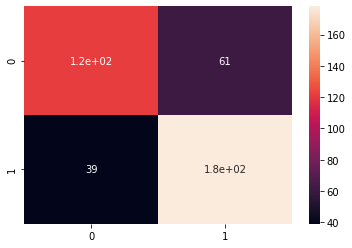

In [ ]:
### doing prediction and calculating Confusion Matrix

pred_BoVW_method = model_xgb.predict(im_features_test)

conf_mat = confusion_matrix(y_test[:config.TESTING_SET_SIZE],
                            pred_BoVW_method)

sns.heatmap(conf_mat, annot=True)